## Plot individual ensemble members for AR events with varying initialization times
**Author: Deanna Nash**

This notebook plots individual ensemble member's IVT and bias (model - observation) for the selected AR dates and intialization dates.

In [1]:
%matplotlib inline
import xarray as xr
import glob
import copy
import numpy as np
from datetime import datetime
import os
import sys
import pandas as pd

# plotting modules
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from shapely.geometry.polygon import LinearRing
from IPython.display import Image, display
from cartopy.mpl.geoaxes import GeoAxes
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import cmocean
import cmocean.cm as cmo

# other modules
import copy
import fsspec
# import xskillscore as xs

## import personal modules
sys.path.append('../modules') # Path to modules
from plotter import draw_basemap

In [2]:
# Set up paths

path_to_data = '/glade/scratch/acsubram/S2S_Database/'                            # project data -- read only
path_to_out  = '/glade/work/dlnash/asp2021/USWest_Water/output/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/glade/work/dlnash/asp2021/USWest_Water/figs/'      # figures

In [3]:
# parameters to set

# lat/lon bounds
latwant=[66,24] # North-to-South
lonwant=[140,240] # degrees East ... But what does that mean on a globe really? 

# plot bounds
lonmin= lonwant[0]
lonmax=lonwant[1]
latmin=latwant[1]
latmax=latwant[0]

## Open the Obs ERA5 files: <a class="anchor" id="fifth-bullet"></a>

In [4]:
# list of files
filenames = sorted(glob.glob(path_to_data + 'ERA5/ERA5_IVT_*.nc'))

fillys = len(filenames)
# just opening the first file for lats and lons
bb = xr.open_dataset(filenames[0])
lat = np.array(bb['latitude'])
lon = np.array(bb['longitude'])


compivt = np.zeros([fillys,lat.shape[0],lon.shape[0]])
comptime = np.zeros([fillys],dtype='datetime64[ns]')
for ii, fname in enumerate(filenames):
    bb = xr.open_dataset(fname)
    ivt = np.array(bb['ivt'])
    compivt[ii,:,:] = ivt
    comptime[ii] = np.array(bb['time'])
    
# load into xarray ds    
IVT_obs = xr.Dataset(
    {
        "IVT": (["time","latitude", "longitude"],compivt),    
    },
    coords={
        "time":comptime,
        "latitude":lat,
        "longitude":lon,
    },)

# Convert longitude coordinates from 0-359 to -180-179
# this doesn't work??
# IVT_obs = IVT_obs.assign_coords(longitude=(((IVT_obs.longitude + 180) % 360) - 180))
IVT_obs

<xarray.Dataset>
Dimensions:    (latitude: 121, longitude: 240, time: 182)
Coordinates:
  * time       (time) datetime64[ns] 2016-12-01 2016-12-02 ... 2017-05-31
  * latitude   (latitude) float64 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * longitude  (longitude) float64 0.0 1.5 3.0 4.5 ... 354.0 355.5 357.0 358.5
Data variables:
    IVT        (time, latitude, longitude) float64 31.19 31.19 ... 4.197 4.197

## Load the forecasts <a class="anchor" id="sixth-bullet"></a>

This next cell is gathering the forecasts and observations into two seperate Xarray structures so that they can be compared

In [5]:
# Find your list of forecast files: 
FilList = sorted(glob.glob(path_to_data + 'IVT*2*.nc'))
FilList = FilList[0:30] # this is as far out as we can go

# open forecast files
df = xr.open_dataset(FilList[0])
df
# valid time = step
# number = ensemble member

<xarray.Dataset>
Dimensions:     (latitude: 121, longitude: 240, number: 50, step: 47)
Coordinates:
  * number      (number) int64 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
    time        datetime64[ns] ...
  * step        (step) timedelta64[ns] 0 days 1 days 2 days ... 45 days 46 days
  * latitude    (latitude) float64 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * longitude   (longitude) float64 0.0 1.5 3.0 4.5 ... 354.0 355.5 357.0 358.5
    valid_time  (step) datetime64[ns] ...
Data variables:
    ivt         (number, step, latitude, longitude) float32 ...

In [6]:
%%time


#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
##################################################################
#create a weight matrix to scale by latitude (higher latitude = less area)
##################################################################

weight_r = np.cos(np.deg2rad(df.latitude))
_, weight_r = xr.broadcast(df,weight_r)
weight_r  = weight_r.isel(step=0,number=0)
##################################################################
##################################################################
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
##################################################################
#initialize array's 
##################################################################
nens, nstep, nlats, nlons =np.array(df['ivt']).shape
compiled_forecast = np.zeros([len(FilList),nens, nstep, nlats, nlons])
compiled_obs = np.zeros([len(FilList),nstep,nlats,nlons])
# leader = date forecast is valid for?
# the time steps in the current forecast file
valid_time = np.zeros([len(FilList), nstep], dtype='datetime64[ns]') 
# issued = date forcast was initialized
# the first valid timestep in each forecast file
initialization = np.zeros([len(FilList)], dtype='datetime64[ns]')
##################################################################
##################################################################
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

for yy,dd  in enumerate(FilList):
    print('Doing Forecast',dd)
    df = xr.open_dataset(dd)
    compiled_forecast[yy,:,:,:,:] = np.array(((df['ivt'])))## - np.expand_dims(OBS_clim,axis=1))) This is where you subtract lead time bias Aneesh! 
    # slice to valid time in observations
    observations = IVT_obs.sel(time=slice(df.valid_time.values[0],df.valid_time.values[-1])).IVT
    # assign valid times for forecast = [issued, lead]
    valid_time[yy,:] = df.valid_time.values
    # assign the initialization date [issued]
    # the first valid_time in each forecast file
    initialization[yy] = df.valid_time.values[0]
    #+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    ##################################################################
    ##################################################################
    
    #HAVE TO FLIP THE OBS LATITUDE!
#     observations = observations.reindex(latitude=list(reversed(observations.latitude)))
    ##################################################################
    ##################################################################
    #+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    
    compiled_obs[yy,:,:,:] = observations ##
#     if yy == 3:
#         break
    
leader = np.arange(0,47,1) # the time steps in the current forecast file
lat = np.array(df.latitude)
lon = np.array(df.longitude)
number = np.arange(0,50,1) # ensemble number
issued=np.arange(0,len(FilList),1) # date forcast was initialized


#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
##################################################################
# # compiled forecasts in Xarray's:
##################################################################


C_for = xr.Dataset(
    {
        "ivt": (["issued","ensemble","lead","latitude", "longitude"],compiled_forecast),
        "forecast_time": (["issued","lead"],valid_time),
#         "initial_date": (["issued"],initialization),
    },
    coords={
        "issued":  initialization, 
        "lead":  leader,
        "ensemble":number,
        "latitude":lat,
        "longitude":lon,
    },)

C_for.attrs["title"] = "EC S2S IVT Forecast "
C_for.ivt.attrs['units'] = 'kg m-1 s-1'
C_for.ivt.attrs['standard_name']='Integrated Vapor Transport'
C_for.ivt.attrs['long_name']='Integrated Vapor Transport'
##################################################################
##################################################################
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++



#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
########################################################
#compiled obs in Xarray's:
########################################################
lat = np.array(df.latitude)
lon = np.array(df.longitude)
C_obs = xr.Dataset(
    {
        "ivt": (["issued","lead","latitude", "longitude"],compiled_obs),
        "forecast_time": (["issued","lead"],valid_time),
#         "initial_date": (["issued"],initialization),
    },
    coords={
        "issued":initialization,
        "lead":leader,
        "latitude":lat,
        "longitude":lon,
    },)
# assign attributes
C_obs.attrs["title"] = "EC S2S IVT Forecast "
C_obs.ivt.attrs['units'] = 'kg m-1 s-1'
C_obs.ivt.attrs['standard_name']='Integrated Vapor Transport'
C_obs.ivt.attrs['long_name']='Integrated Vapor Transport'


########################################################
########################################################
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++



#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
##################################################################
#subset for region:
##################################################################
C_for_roi = C_for.sel(latitude=slice(latwant[0],latwant[1]),longitude=slice(lonwant[0],lonwant[1]))
C_obs_roi = C_obs.sel(latitude=slice(latwant[0],latwant[1]),longitude=slice(lonwant[0],lonwant[1]))
print('...do ensemble mean...')
C_for_roi_ensemean = C_for_roi.mean('ensemble')
print('....done....')
##################################################################
##################################################################
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++



Doing Forecast /glade/scratch/acsubram/S2S_Database/IVT_20170102.nc
Doing Forecast /glade/scratch/acsubram/S2S_Database/IVT_20170105.nc
Doing Forecast /glade/scratch/acsubram/S2S_Database/IVT_20170109.nc
Doing Forecast /glade/scratch/acsubram/S2S_Database/IVT_20170112.nc
Doing Forecast /glade/scratch/acsubram/S2S_Database/IVT_20170116.nc
Doing Forecast /glade/scratch/acsubram/S2S_Database/IVT_20170119.nc
Doing Forecast /glade/scratch/acsubram/S2S_Database/IVT_20170123.nc
Doing Forecast /glade/scratch/acsubram/S2S_Database/IVT_20170126.nc
Doing Forecast /glade/scratch/acsubram/S2S_Database/IVT_20170130.nc
Doing Forecast /glade/scratch/acsubram/S2S_Database/IVT_20170202.nc
Doing Forecast /glade/scratch/acsubram/S2S_Database/IVT_20170206.nc
Doing Forecast /glade/scratch/acsubram/S2S_Database/IVT_20170209.nc
Doing Forecast /glade/scratch/acsubram/S2S_Database/IVT_20170213.nc
Doing Forecast /glade/scratch/acsubram/S2S_Database/IVT_20170216.nc
Doing Forecast /glade/scratch/acsubram/S2S_Datab

In [7]:
#recalculate your weight matrix 
weight_r = weight_r.sel(latitude=slice(latwant[0],latwant[1]),longitude=slice(lonwant[0],lonwant[1]))
Spread= C_for_roi.ivt.std("ensemble").weighted(weight_r).mean(("latitude","longitude","issued")).data

## Plot Ensemble Mean

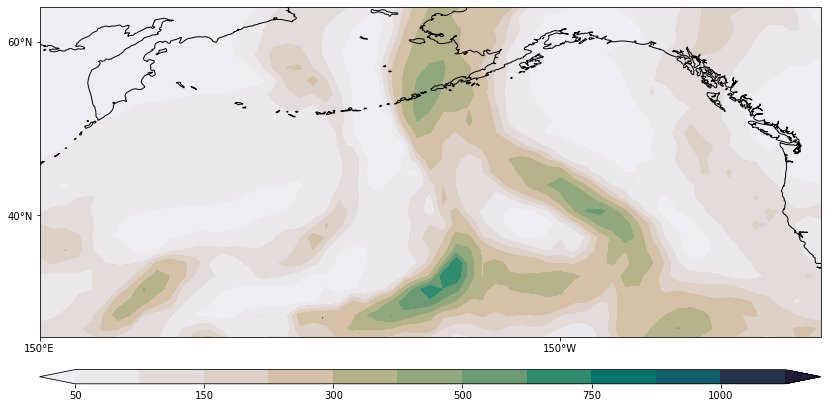

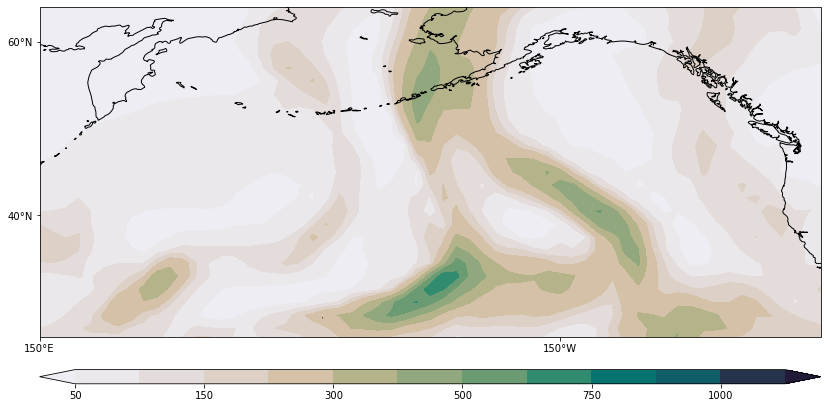

In [8]:
ivt_plt = np.array(C_for_roi.isel(issued=0,lead=0).ivt.mean('ensemble'))
lon = np.array(C_for_roi['longitude'])
lat = np.array(C_for_roi['latitude'])

mapcrs = ccrs.PlateCarree(central_longitude=180.0, globe=None)

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=mapcrs)
ax.set_extent([150, 240 , 25, 65], ccrs.PlateCarree())
# ax.set_xticks([0, 60, 120, 180, 240, 300, 360], crs=ccrs.PlateCarree())
ax.set_xticks([150, 210, 260, 320], crs=ccrs.PlateCarree())
ax.set_yticks([0, 20, 40, 60], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

# Add geopolitical boundaries for map reference
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.set_extent([150, 240 , 26, 64], ccrs.PlateCarree())


# Plot IVT
clevs = [50,100,150,200,300,400,500,600,750,850,1000,1250]
cf = ax.contourf(lon, lat, ivt_plt , clevs, cmap = cmocean.cm.rain,
                 transform=datacrs, extend="both")
#cmap=plt.cm.BuPu

plt.colorbar(cf, orientation='horizontal', pad=0.05, aspect=50)
plt.show()
# fig.savefig('AR_Track_ens1.png', bbox_inches='tight')

###################################################################
###################################################################

###################################################################
ivt_plt = np.array(C_obs_roi.isel(issued=0,lead=0).ivt)
lon = np.array(C_obs_roi['longitude'])
lat = np.array(C_obs_roi['latitude'])

mapcrs = ccrs.PlateCarree(central_longitude=180.0, globe=None)

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=mapcrs)
# ax.set_xticks([0, 60, 120, 180, 240, 300, 360], crs=ccrs.PlateCarree())
ax.set_xticks([150, 210, 260, 320], crs=ccrs.PlateCarree())
ax.set_yticks([0, 20, 40, 60], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

# Add geopolitical boundaries for map reference
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.set_extent([150, 240 , 26, 64], ccrs.PlateCarree())


# Plot IVT
clevs = [50,100,150,200,300,400,500,600,750,850,1000,1250]
cf = ax.contourf(lon, lat, ivt_plt , clevs, cmap = cmocean.cm.rain,
                 transform=datacrs, extend="both")
#cmap=plt.cm.BuPu

plt.colorbar(cf, orientation='horizontal', pad=0.05, aspect=50)
plt.show()
# fig.savefig('AR_Track_ens1.png', bbox_inches='tight')


## Plot individual ensemble member (9 plots)

In [9]:
C_for_roi

<xarray.Dataset>
Dimensions:        (ensemble: 50, issued: 30, latitude: 27, lead: 47, longitude: 67)
Coordinates:
  * issued         (issued) datetime64[ns] 2017-01-02 2017-01-05 ... 2017-04-13
  * lead           (lead) int64 0 1 2 3 4 5 6 7 8 ... 38 39 40 41 42 43 44 45 46
  * ensemble       (ensemble) int64 0 1 2 3 4 5 6 7 ... 42 43 44 45 46 47 48 49
  * latitude       (latitude) float64 64.5 63.0 61.5 60.0 ... 28.5 27.0 25.5
  * longitude      (longitude) float64 141.0 142.5 144.0 ... 237.0 238.5 240.0
Data variables:
    ivt            (issued, ensemble, lead, latitude, longitude) float64 3.492 ... 54.07
    forecast_time  (issued, lead) datetime64[ns] 2017-01-02 ... 2017-05-29
Attributes:
    title:    EC S2S IVT Forecast

In [10]:
# select initialization date
# we are interested in 2 week lead and 3 week lead
# initial_dt2 = '2017-01-16 0:00' # 2-week lead for AR event 1
# initial_dt3 = '2017-01-09 0:00' # 3-week lead for AR event 1

initial_dt2 = '2017-01-23 0:00' # 2-week lead for AR event 2
initial_dt3 = '2017-01-16 0:00' # 3-week lead for AR event 2

# select AR event dates
# AR_dates = ['2017-01-29 0:00', '2017-02-03 0:00'] # AR event 1
AR_dates = ['2017-02-05 0:00', '2017-02-10 0:00'] # AR event 2

tmp_for = C_for_roi.sel(issued=initial_dt2)
tmp_obs = C_obs_roi.sel(issued=initial_dt2)
# this methodology for indexing below didn't work
# idx = C_for_roi.where(C_for_roi.issued==initial_dt2, drop=False)
# # tmp_obs = C_obs_roi.where(C_obs_roi.initial_date==initial_dt2, drop=True)

# now assign forecast time as the lead coordinate for indexing AR dates
tmp_for = tmp_for.assign(lead=lambda tmp_for: tmp_for.forecast_time)
tmp_obs = tmp_obs.assign(lead=lambda tmp_obs: tmp_obs.forecast_time)

# set start and end dates
start_date = AR_dates[0]
end_date = AR_dates[1]

tmp_for = tmp_for.sel(lead=slice(start_date, end_date))
tmp_obs = tmp_obs.sel(lead=slice(start_date, end_date))
tmp_for

<xarray.Dataset>
Dimensions:        (ensemble: 50, latitude: 27, lead: 6, longitude: 67)
Coordinates:
    issued         datetime64[ns] 2017-01-23
  * lead           (lead) datetime64[ns] 2017-02-05 2017-02-06 ... 2017-02-10
  * ensemble       (ensemble) int64 0 1 2 3 4 5 6 7 ... 42 43 44 45 46 47 48 49
  * latitude       (latitude) float64 64.5 63.0 61.5 60.0 ... 28.5 27.0 25.5
  * longitude      (longitude) float64 141.0 142.5 144.0 ... 237.0 238.5 240.0
Data variables:
    ivt            (ensemble, lead, latitude, longitude) float64 15.09 ... 65.8
    forecast_time  (lead) datetime64[ns] 2017-02-05 2017-02-06 ... 2017-02-10
Attributes:
    title:    EC S2S IVT Forecast

In [11]:
da = tmp_obs.ivt
da

<xarray.DataArray 'ivt' (lead: 6, latitude: 27, longitude: 67)>
array([[[ 36.70880127,  41.70368576,  46.19868469, ...,  41.46655273,
          30.01958847,  26.8869915 ],
        [ 32.01159286,  37.76937866,  46.24549866, ...,  42.74601364,
          28.49442673,  30.04527855],
        [ 27.90896606,  34.84279633,  42.43625259, ...,  45.71292496,
          30.1947155 ,  29.77315903],
        ...,
        [254.42625427, 231.04922485, 208.89492798, ...,  67.88508606,
          67.90000916,  64.24425507],
        [185.41401672, 170.17378235, 165.61347961, ...,  49.54044342,
          63.95082474,  68.08759308],
        [111.5605545 , 107.33627319, 105.83622742, ...,  21.59097862,
          42.41156006,  59.46295166]],

       [[ 29.84463882,  35.44289398,  36.89022064, ...,  42.55978394,
          35.92282104,  28.40922737],
        [ 23.33533669,  29.63508606,  32.95452118, ...,  52.88928986,
          43.78089142,  32.47734833],
        [ 19.84199715,  23.45578003,  29.12582588, ...,  52.61962128,
          43.62994003,  32.26145935],
        ...,
        [536.7746582 , 602.88702393, 582.51165771, ..., 276.10742188,
         226.95446777, 206.31581116],
        [608.80596924, 549.63586426, 553.93530273, ..., 182.42692566,
         157.08534241, 161.55921936],
        [519.89282227, 481.63818359, 540.27587891, ..., 134.25314331,
         131.91087341, 130.22596741]],

       [[ 21.61264801,  21.39476013,  21.73171234, ...,  69.27256775,
          65.54077148,  59.32870865],
        [ 21.46434784,  21.65793228,  22.6063385 , ...,  48.49339676,
          48.29938126,  43.04867172],
        [ 25.28123856,  29.79790497,  36.30360794, ...,  26.93875504,
          23.08623314,  18.39585876],
        ...,
        [207.2388916 , 220.01493835, 240.73550415, ..., 240.73228455,
         259.50704956, 279.67431641],
        [186.00263977, 225.94447327, 260.63198853, ..., 146.94114685,
         139.72528076, 129.3883667 ],
        [188.1308136 , 265.87329102, 372.01809692, ...,  85.39987183,
          91.74467468, 102.70156097]],

       [[ 38.66242599,  38.49468994,  39.99709702, ...,  55.04248428,
          55.23106766,  51.56761169],
        [ 46.41021347,  47.20279694,  49.9275589 , ...,  48.22529221,
          51.90856171,  45.51228333],
        [ 46.43822479,  47.57110977,  50.09838867, ...,  38.90190887,
          45.03269196,  42.17782593],
        ...,
        [166.06509399, 193.28509521, 214.42451477, ...,  96.78842163,
          94.33650208, 117.68292236],
        [130.82499695, 152.61643982, 183.29074097, ...,  29.55010414,
          48.11375809,  83.89382172],
        [ 85.77593231, 102.67090607, 135.84973145, ...,  40.73060226,
          55.56619263,  87.25991821]],

       [[ 29.67173958,  27.5650959 ,  26.22709274, ...,  63.84492874,
          64.86126709,  63.64884186],
        [ 30.94482994,  28.84272575,  27.34264946, ...,  62.00780869,
          68.8112793 ,  74.13536072],
        [ 26.58699226,  29.19932175,  29.69446754, ...,  37.75130844,
          50.29166412,  64.0861969 ],
        ...,
        [234.56196594, 222.53161621, 223.80548096, ...,  87.67528534,
          24.10655212,  46.64712143],
        [119.91873932, 116.27377319, 120.05337524, ...,  57.27387238,
          42.63211441,  46.19926071],
        [ 88.59143829,  86.69972992,  92.01068115, ...,  56.50123978,
          45.72507858,  48.17815781]],

       [[ 29.64948845,  22.10827065,  17.25039291, ...,  18.87360954,
          19.71608353,  21.38332367],
        [ 17.46998405,  14.09644794,  13.67552662, ...,  17.00039291,
          14.66391277,  14.89725018],
        [ 12.24743557,  11.95251751,  13.78553009, ...,  19.05093002,
          14.82284832,  12.9613924 ],
        ...,
        [321.86712646, 360.40640259, 380.07424927, ..., 147.15386963,
         103.44941711,  76.62404633],
        [355.60742188, 374.47833252, 350.15075684, ...,  95.94171906,
          54.59715652,  34.38488007],
        [308.53182983, 323.59747314, 331.20874023, ...,  53.94305038

In [12]:
def plot_individual_ens(ens):
    nleads = len(tmp_for.lead)

    # plot bounds
    lonmin = tmp_for.longitude.min()
    lonmax = tmp_for.longitude.max()
    latmin = tmp_for.latitude.min()
    latmax = tmp_for.latitude.max()

    # Data for plotting 
    lons = tmp_for.longitude.values
    lats = tmp_for.latitude.values

    # Set up projection
    mapcrs = ccrs.PlateCarree(central_longitude=180.0, globe=None)
    datacrs = ccrs.PlateCarree()

    # Set tick/grid locations
    dx = np.arange(lonmin,lonmax+10,10)
    dy = np.arange(latmin,latmax+10,10)

    # plot title
    date = tmp_for.issued.values
    ts = pd.to_datetime(str(date)) 
    d = ts.strftime('%Y.%m.%d')
    plt_title = 'Ensemble Number {0}, Forecast Issued: {1}'.format(ens, d,)

    # subtitles
    plt_lbl = []
    plt_lbl2 = []
    for k in range(nleads):
        date2 = tmp_for.lead.isel(lead=k).values
        ts2 = pd.to_datetime(str(date2)) 
        d2 = ts2.strftime('%Y.%m.%d')
        plt_lbl.append("Valid date: {0}".format(d2,))
        # calculate number of lead days
        x = date2 - date
        days = x.astype('timedelta64[D]')
        ndays = days / np.timedelta64(1, 'D')
        plt_lbl2.append("{:1d}-day lead".format(int(ndays),))

    # other plot parameters
    cmap = cmo.deep
    cb_lbl = 'kg m$^{-1}$ s$^{-1}$'
    cflevs = [50,100,150,200,300,400,500,600,750,850,1000,1250]
    ext = [lonmin,lonmax,latmin,latmax]
    
    # Create IVT mag figure
    fig = plt.figure(figsize=(15,15))
    fname1 = path_to_figs + 'ens_IVT/ensemble{0}_IVT_2wklead_AR2'.format(ens)
    nrows = 3
    ncols = 2

    # Set up Axes Grid
    axes_class = (GeoAxes,dict(map_projection=mapcrs))
    axgr = AxesGrid(fig, 
                    111, 
                    axes_class=axes_class,
                    nrows_ncols=(nrows, ncols), 
                    axes_pad = 0.55,
                    cbar_location='bottom', 
                    cbar_mode='single',
                    cbar_pad=0.0, 
                    cbar_size='5%',
                    label_mode='')

    # Loop for drawing each plot
    for k, ax in enumerate(axgr):
        ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy)
        ax.set_extent(ext, crs=datacrs)
        # Contour Filled
        data = tmp_for.ivt.isel(ensemble=ens, lead=k).values
        cf = ax.contourf(lons, lats, data, transform=datacrs,
                         levels=cflevs, cmap=cmap, extend='max')

        # subtitles
        ax.set_title(plt_lbl[k], loc='left', fontsize=12)
        ax.set_title(plt_lbl2[k], loc='right', fontsize=12)

    # single colorbar
    cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
    cb.set_label(cb_lbl, fontsize=11)
    cb.ax.tick_params(labelsize=10)

    # set figure title
    # fig.suptitle(plt_title, fontsize=12)
    # Instead, do a hack by annotating the first axes with the desired 
    # string and set the positioning to 'figure fraction'.
    fig.get_axes()[0].annotate(plt_title, (0.5, 0.88), 
                                xycoords='figure fraction', ha='center', 
                                fontsize=12
                                )

    # Display figure
    plt.savefig(fname1, dpi=300, bbox_inches='tight')
    
    ## difference plots
    # other plot parameters
    cmap = cmo.balance
    cb_lbl = 'kg m$^{-1}$ s$^{-1}$'
    cflevs = np.arange(-500., 550, 50)

    # Create figure
    fig = plt.figure(figsize=(15,15))
    fname2 = path_to_figs + 'ens_diffIVT/ensemble{0}_diffIVT_2wklead_AR2'.format(ens)
    nrows = 3
    ncols = 2

    # Set up Axes Grid
    axes_class = (GeoAxes,dict(map_projection=mapcrs))
    axgr = AxesGrid(fig, 
                    111, 
                    axes_class=axes_class,
                    nrows_ncols=(nrows, ncols), 
                    axes_pad = 0.55,
                    cbar_location='bottom', 
                    cbar_mode='single',
                    cbar_pad=0.0, 
                    cbar_size='5%',
                    label_mode='')

    # Loop for drawing each plot
    for k, ax in enumerate(axgr):
        ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy)
        ax.set_extent(ext, crs=datacrs)
        # calculate model bias (observation - model = bias)
        obs_data = tmp_obs.ivt.isel(lead=k).values
        obs_model = tmp_for.ivt.isel(ensemble=ens, lead=k).values
        # Contour Filled
        bias = obs_data - obs_model
        cf = ax.contourf(lons, lats, bias, transform=datacrs,
                         levels=cflevs, cmap=cmap, extend='both')

        # subtitles
        ax.set_title(plt_lbl[k], loc='left', fontsize=12)
        ax.set_title(plt_lbl2[k], loc='right', fontsize=12)

    # single colorbar
    cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
    cb.set_label(cb_lbl, fontsize=11)
    cb.ax.tick_params(labelsize=10)

    # set figure title
    # fig.suptitle(plt_title, fontsize=12)
    # Instead, do a hack by annotating the first axes with the desired 
    # string and set the positioning to 'figure fraction'.
    fig.get_axes()[0].annotate(plt_title, (0.94, 0.88), 
                                xycoords='figure fraction', ha='right', 
                                fontsize=12
                                )
    fig.get_axes()[0].annotate('observation - model = bias', (0.07, 0.88), 
                                xycoords='figure fraction', ha='left', 
                                fontsize=12
                                )

    # Display figure
    plt.savefig(fname2, dpi=300, bbox_inches='tight')
    
    plt.close('all')

In [13]:
# choose number of ensembles to plot
nens = len(tmp_for.ensemble)
for i in range(nens):
    ens = i
    plot_individual_ens(ens)

In [14]:
plt.close('all')